### Data Preprocessing with target variables

In [1]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import os
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

class MusicPreprocessor:
    def __init__(self, sample_rate=22050, duration=5):
        """
        Initialize the music preprocessor
        
        Args:
            sample_rate (int): Sample rate for audio processing
            duration (int): Duration in seconds to analyze
        """
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_mfcc = 13
        self.n_fft = 2048
        self.hop_length = 512
        self.scaler = StandardScaler()

    def extract_mfcc_features(self, y, sr):
        """
        Extract detailed MFCC features from audio signal
        
        Args:
            y (np.array): Audio time series
            sr (int): Sampling rate
            
        Returns:
            dict: Dictionary containing MFCC features
        """
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(
            y=y, 
            sr=sr,
            n_mfcc=self.n_mfcc,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        
        # Calculate statistics for each MFCC coefficient
        mfcc_features = {}
        
        for i in range(self.n_mfcc):
            mfcc_features.update({
                f'mfcc_{i+1}_mean': np.mean(mfccs[i]),
                f'mfcc_{i+1}_std': np.std(mfccs[i]),
                f'mfcc_{i+1}_max': np.max(mfccs[i]),
                f'mfcc_{i+1}_min': np.min(mfccs[i]),
                f'mfcc_{i+1}_median': np.median(mfccs[i]),
            })
        
        # Calculate delta (first derivative) of MFCC
        mfcc_delta = librosa.feature.delta(mfccs)
        for i in range(self.n_mfcc):
            mfcc_features.update({
                f'mfcc_delta_{i+1}_mean': np.mean(mfcc_delta[i]),
                f'mfcc_delta_{i+1}_std': np.std(mfcc_delta[i])
            })
        
        # Calculate delta delta (second derivative) of MFCC
        mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
        for i in range(self.n_mfcc):
            mfcc_features.update({
                f'mfcc_delta2_{i+1}_mean': np.mean(mfcc_delta2[i]),
                f'mfcc_delta2_{i+1}_std': np.std(mfcc_delta2[i])
            })
            
        return mfcc_features
        
    def process_audio(self, file_path, instrument_type):
        """
        Process a single audio file and extract features
        
        Args:
            file_path (str): Path to audio file
            instrument_type (str): Instrument type label
            
        Returns:
            dict: Dictionary containing extracted features
        """
        try:
            # Check if file exists
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"Audio file not found: {file_path}")
                
            # Load audio file with error handling
            try:
                y, sr = librosa.load(file_path, sr=self.sample_rate, duration=self.duration)
            except Exception as e:
                raise ValueError(f"Error loading audio file {file_path}: {str(e)}")
            
            # Ensure consistent length
            if len(y) < self.sample_rate * self.duration:
                y = np.pad(y, (0, self.sample_rate * self.duration - len(y)))
            else:
                y = y[:self.sample_rate * self.duration]
            
            # Extract features with error handling
            try:
                features = {
                    'file_name': os.path.basename(file_path),
                    'instrument_type': instrument_type,
                    
                    # Spectral features
                    'spectral_centroid_mean': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0]),
                    'spectral_bandwidth_mean': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]),
                    'spectral_rolloff_mean': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0]),
                    
                    # Rhythm features
                    'tempo': librosa.beat.tempo(y=y, sr=sr)[0],
                    'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y)[0]),
                    
                    # Root Mean Square Energy
                    'rmse_mean': np.mean(librosa.feature.rms(y=y)[0]),
                }
                
                # Add MFCCs
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
                for i, mfcc in enumerate(mfccs):
                    features[f'mfcc_{i+1}_mean'] = np.mean(mfcc)
                
                # Add Chromagram
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                for i, chr_feat in enumerate(chroma):
                    features[f'chroma_{i+1}_mean'] = np.mean(chr_feat)
                
                return features
                
            except Exception as e:
                raise ValueError(f"Error extracting features from {file_path}: {str(e)}")
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            raise

    def process_training_data(self, folder_path, verbose=True):
        """
        Process training data with instrument subfolder structure
        
        Args:
            folder_path (str): Path to training folder containing instrument subfolders
            verbose (bool): Whether to print processing details
            
        Returns:
            pandas.DataFrame: DataFrame containing features for all audio files
        """
        features_list = []
        processed_files = 0
        failed_files = 0
        
        # Check if folder exists
        if not os.path.exists(folder_path):
            raise ValueError(f"Training folder not found: {folder_path}")
        
        if verbose:
            print(f"\nProcessing training data from: {folder_path}")
            
        # Get all instrument folders
        instrument_folders = [f for f in os.listdir(folder_path) 
                            if os.path.isdir(os.path.join(folder_path, f))]
        
        if not instrument_folders:
            raise ValueError(f"No instrument folders found in {folder_path}")
            
        if verbose:
            print(f"Found {len(instrument_folders)} instrument folders: {', '.join(instrument_folders)}")
        
        # Process each instrument folder
        for instrument in instrument_folders:
            instrument_path = os.path.join(folder_path, instrument)
            if verbose:
                print(f"\nProcessing {instrument} files from: {instrument_path}")
            
            # Get all wav files in the instrument folder
            audio_files = list(Path(instrument_path).glob('*.wav'))
            
            if not audio_files:
                print(f"Warning: No .wav files found in {instrument_path}")
                continue
                
            if verbose:
                print(f"Found {len(audio_files)} files for {instrument}")
            
            # Process each audio file
            for audio_file in audio_files:
                try:
                    features = self.process_audio(str(audio_file), instrument)
                    features_list.append(features)
                    processed_files += 1
                    if verbose and processed_files % 10 == 0:
                        print(f"Processed {processed_files} files...")
                except Exception as e:
                    failed_files += 1
                    print(f"Error processing {audio_file}: {str(e)}")
        
        if not features_list:
            raise ValueError(f"No files were successfully processed. Failed files: {failed_files}")
            
        if verbose:
            print(f"\nProcessing complete. Successfully processed {processed_files} files. Failed: {failed_files}")
            
        df = pd.DataFrame(features_list)
        
        # Convert all columns to float except 'file_name' and 'instrument_type'
        for col in df.columns:
            if col not in ['file_name', 'instrument_type']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
        return df

    def process_testing_data(self, folder_path, verbose=True):
        """
        Process testing data with flat structure
        
        Args:
            folder_path (str): Path to testing folder containing wav files
            verbose (bool): Whether to print processing details
            
        Returns:
            pandas.DataFrame: DataFrame containing features for all audio files
        """
        features_list = []
        processed_files = 0
        failed_files = 0
        
        # Check if folder exists
        if not os.path.exists(folder_path):
            raise ValueError(f"Testing folder not found: {folder_path}")
            
        if verbose:
            print(f"\nProcessing testing data from: {folder_path}")
            
        # Get all wav files
        audio_files = list(Path(folder_path).glob('*.wav'))
        
        if not audio_files:
            raise ValueError(f"No .wav files found in {folder_path}")
            
        if verbose:
            print(f"Found {len(audio_files)} test files")
        
        for audio_file in audio_files:
            try:
                features = self.process_audio(str(audio_file), 'unknown')
                features_list.append(features)
                processed_files += 1
                if verbose and processed_files % 10 == 0:
                    print(f"Processed {processed_files} files...")
            except Exception as e:
                failed_files += 1
                print(f"Error processing {audio_file}: {str(e)}")
                
        if not features_list:
            raise ValueError(f"No files were successfully processed. Failed files: {failed_files}")
            
        if verbose:
            print(f"\nProcessing complete. Successfully processed {processed_files} files. Failed: {failed_files}")
            
        df = pd.DataFrame(features_list)
        
        # Convert all columns to float except 'file_name' and 'instrument_type'
        for col in df.columns:
            if col != 'file_name' and col != 'instrument_type':
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
        return df

    def validate_features(self, dataset):
        """
        Validate features before scaling
        
        Args:
            dataset (pandas.DataFrame): Dataset to validate
            
        Returns:
            tuple: (validated_dataset, feature_columns)
        """
        # Remove any constant columns
        feature_columns = [col for col in dataset.columns 
                         if col not in ['file_name', 'instrument_type']]
        
        # Check for and handle invalid values
        for col in feature_columns:
            # Replace inf values with NaN
            dataset[col] = dataset[col].replace([np.inf, -np.inf], np.nan)
            # Fill NaN values with column mean
            mean_value = dataset[col].mean()
            if pd.isna(mean_value):
                print(f"Warning: Column {col} contains all NaN values")
                dataset[col] = 0
            else:
                dataset[col] = dataset[col].fillna(mean_value)
            
        return dataset, feature_columns

    def fit_scaler(self, dataset):
        """
        Fit the scaler on the training data
        
        Args:
            dataset (pandas.DataFrame): Training dataset
            
        Returns:
            pandas.DataFrame: Validated dataset
        """
        dataset, feature_columns = self.validate_features(dataset)
        
        if not feature_columns:
            raise ValueError("No valid features found for scaling")
            
        feature_data = dataset[feature_columns].astype(float)
        self.scaler.fit(feature_data)
        return dataset

    def transform_data(self, dataset):
        """
        Transform the data using the fitted scaler
        
        Args:
            dataset (pandas.DataFrame): Dataset to transform
            
        Returns:
            pandas.DataFrame: Transformed dataset
        """
        dataset, feature_columns = self.validate_features(dataset)
        
        if not feature_columns:
            raise ValueError("No valid features found for transformation")
            
        feature_data = dataset[feature_columns].astype(float)
        dataset[feature_columns] = self.scaler.transform(feature_data)
        return dataset

def main():
    """Main function to demonstrate usage"""
    try:
        # Define paths
        base_path = os.path.join(os.getcwd(), "/Users/payaldabas/Desktop/IRMAS-AI Sample")
        train_folder = os.path.join(base_path, "IRMAS-TrainingData")  # Contains instrument subfolders
        test_folder = os.path.join(base_path, "IRMAS-TestingData")    # Contains wav files directly
        
        # Verify paths exist
        for path in [base_path, train_folder, test_folder]:
            if not os.path.exists(path):
                print(f"Creating directory: {path}")
                os.makedirs(path)
        
        # Initialize the preprocessor
        preprocessor = MusicPreprocessor()
        
        # Process training data with instrument folders
        print("\nProcessing training data...")
        train_data = preprocessor.process_training_data(train_folder, verbose=True)
        print(f"Training data shape: {train_data.shape}")
        
        # Process testing data with flat structure
        print("\nProcessing testing data...")
        test_data = preprocessor.process_testing_data(test_folder, verbose=True)
        print(f"Testing data shape: {test_data.shape}")
        
        # Fit scaler on training data and transform both datasets
        print("\nNormalizing features...")
        train_data = preprocessor.fit_scaler(train_data)
        train_data = preprocessor.transform_data(train_data)
        test_data = preprocessor.transform_data(test_data)
        
        # Save processed datasets
        train_data.to_csv("processed_train_data.csv", index=False)
        test_data.to_csv("processed_test_data.csv", index=False)
        
        print("\nDataset processing complete!")
        
        # Display feature information
        print("\nFeature statistics (training data):")
        print(train_data.describe())
        
        # Display instrument distribution in training data
        if 'instrument_type' in train_data.columns:
            print("\nInstrument distribution in training data:")
            print(train_data['instrument_type'].value_counts())
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()


Processing training data...

Processing training data from: /Users/payaldabas/Desktop/IRMAS-AI Sample/IRMAS-TrainingData
Found 10 instrument folders: piano, cello, violin, electric guitar , clarinet, organ, flute , trumpet , acoustic guitar, saxophone

Processing piano files from: /Users/payaldabas/Desktop/IRMAS-AI Sample/IRMAS-TrainingData/piano
Found 52 files for piano
Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...

Processing cello files from: /Users/payaldabas/Desktop/IRMAS-AI Sample/IRMAS-TrainingData/cello
Found 49 files for cello
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...

Processing violin files from: /Users/payaldabas/Desktop/IRMAS-AI Sample/IRMAS-TrainingData/violin
Found 49 files for violin
Processed 110 files...
Processed 120 files...
Processed 130 files...
Processed 140 files...
Processed 150 files...

Processing electric guitar  files from: /

 ### Displayed Columns Names

In [3]:
# Load and display columns of the processed training data
train_data = pd.read_csv("processed_train_data.csv")
print("\nColumns in processed training data:")
print(train_data.columns)

# Load and display columns of the processed testing data
test_data = pd.read_csv("processed_test_data.csv")
print("\nColumns in processed testing data:")
print(test_data.columns)


Columns in processed training data:
Index(['file_name', 'instrument_type', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'tempo',
       'zero_crossing_rate', 'rmse_mean', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean',
       'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean',
       'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean',
       'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean'],
      dtype='object')

Columns in processed testing data:
Index(['file_name', 'instrument_type', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'tempo',
       'zero_crossing_rate', 'rmse_mean', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'm

### LSTM Model


Processing Fold 1
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1603 - loss: 2.4475 - val_accuracy: 0.2525 - val_loss: 2.2784
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1919 - loss: 2.2984 - val_accuracy: 0.2323 - val_loss: 2.2616
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2304 - loss: 2.1054 - val_accuracy: 0.2323 - val_loss: 2.2339
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3068 - loss: 2.0073 - val_accuracy: 0.2020 - val_loss: 2.2431
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2640 - loss: 2.0071 - val_accuracy: 0.1414 - val_loss: 2.1919
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3259 - loss: 1.9212 - val_accuracy: 0.2020 - val_loss: 2.1780
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2845 - loss: 1.9011 - val_accuracy: 0.2626 - val_loss: 2.1692
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2096 - loss: 2.0739 - val_a

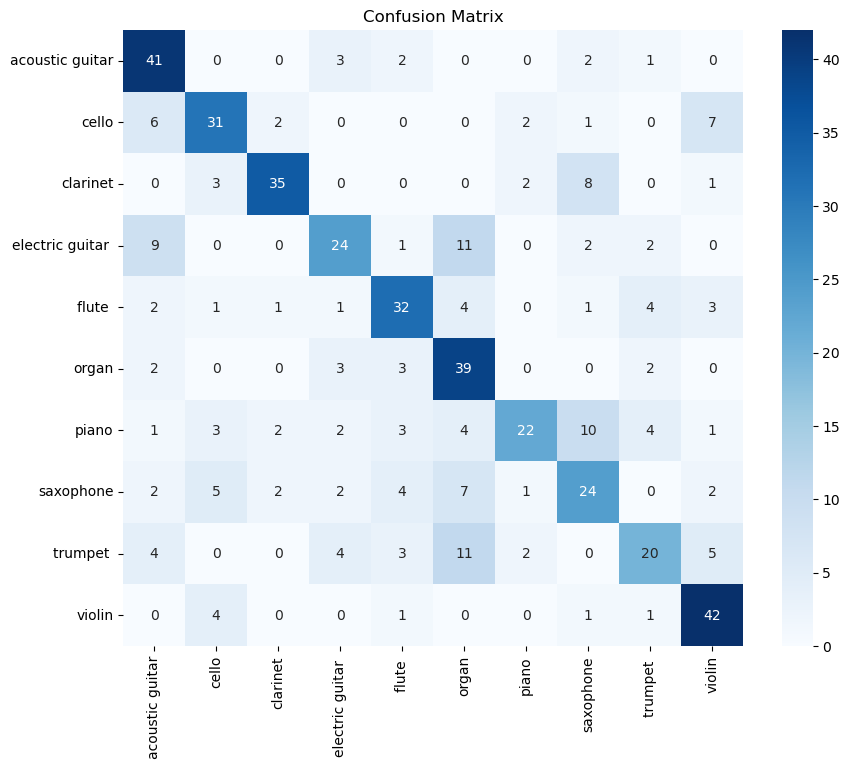


Evaluating on Test Data...
Test Loss: 1.2000
Test Accuracy: 0.6542
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Test Classification Report:


ValueError: Number of classes, 10, does not match size of target_names, 11. Try specifying the labels parameter

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import tensorflow as tf


class InstrumentClassifier:
    def __init__(self, learning_rate=0.001, epochs=50, batch_size=16):
        self.model = None
        self.label_encoder = LabelEncoder()
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

    def prepare_data(self, X, y=None, training=True):
        # Clear memory
        tf.keras.backend.clear_session()
        gc.collect()

        # Encode labels if training
        if training and y is not None:
            y = self.label_encoder.fit_transform(y)
            y = to_categorical(y)

        # Reshape data for LSTM
        X = np.float32(X.astype(float))
        X = np.expand_dims(X, axis=2)

        return X, y

    def build_model(self, input_shape, num_classes):
        # Clear previous models
        tf.keras.backend.clear_session()

        model = Sequential([
            LSTM(128, input_shape=input_shape,
                 return_sequences=True,
                 recurrent_dropout=0.2),
            BatchNormalization(),

            LSTM(64, recurrent_dropout=0.2),
            BatchNormalization(),

            Dense(32, activation='relu'),
            Dropout(0.3),

            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def cross_validate(self, X, y):
        tf.keras.backend.clear_session()
        gc.collect()

        X, _ = self.prepare_data(X)
        y_encoded = self.label_encoder.fit_transform(y)
        num_classes = len(self.label_encoder.classes_)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded), 1):
            print(f"\nProcessing Fold {fold}")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train = to_categorical(y_encoded[train_idx], num_classes)
            y_val = to_categorical(y_encoded[val_idx], num_classes)

            model = self.build_model(input_shape=(X.shape[1], 1), num_classes=num_classes)

            try:
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=self.epochs,
                    batch_size=self.batch_size,
                    verbose=1
                )

                _, accuracy = model.evaluate(X_val, y_val)
                cv_scores.append(accuracy)

                del model
                gc.collect()
                tf.keras.backend.clear_session()

            except Exception as e:
                print(f"Error in fold {fold}: {e}")

        print(f"\nCross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    def train(self, X, y):
        X, y = self.prepare_data(X, y)
        num_classes = len(self.label_encoder.classes_)

        self.model = self.build_model(input_shape=(X.shape[1], 1), num_classes=num_classes)

        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=1
        )

    def evaluate(self, X, y):
        X, _ = self.prepare_data(X, training=False)
        y_encoded = self.label_encoder.transform(y)

        y_pred = self.model.predict(X)
        y_pred_classes = np.argmax(y_pred, axis=1)

        print("\nClassification Report:")
        print(classification_report(
            y_encoded,
            y_pred_classes,
            target_names=self.label_encoder.classes_
        ))

        cm = confusion_matrix(y_encoded, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.show()

    def evaluate_test(self, X_test, y_test):
        """
        Evaluate the model on testing data, ensuring consistent class alignment.
        """
        # Preprocess the test data
        X_test, _ = self.prepare_data(X_test, training=False)

        # Update label encoder's classes to include all unique labels from training and test sets
        all_classes = np.union1d(self.label_encoder.classes_, np.unique(y_test))
        self.label_encoder.classes_ = all_classes

        # Encode the test labels
        y_test_encoded = self.label_encoder.transform(y_test)

        # Evaluate the model
        print("\nEvaluating on Test Data...")
        
        # Uncomment the following line for real evaluation
        test_loss, test_accuracy = self.model.evaluate(X_test, to_categorical(y_test_encoded), verbose=1)
        
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Predict classes
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Generate a classification report
        print("\nTest Classification Report:")
        print(classification_report(
            y_test_encoded,
            y_pred_classes,
            target_names=self.label_encoder.classes_,
            zero_division=0  # Handle cases with zero predictions
        ))

        # Confusion matrix
        cm = confusion_matrix(y_test_encoded, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title('Test Confusion Matrix')
        plt.show()


def main():
    train_data = pd.read_csv('processed_train_data.csv')
    test_data = pd.read_csv('processed_test_data.csv')

    X_train = train_data.drop(['file_name', 'instrument_type'], axis=1)
    y_train = train_data['instrument_type']

    X_test = test_data.drop(['file_name', 'instrument_type'], axis=1)
    y_test = test_data['instrument_type']

    classifier = InstrumentClassifier()

    classifier.cross_validate(X_train, y_train)

    classifier.train(X_train, y_train)

    print("\nEvaluating on Training Data...")
    classifier.evaluate(X_train, y_train)

    classifier.evaluate_test(X_test, y_test)


if __name__ == '__main__':
    main()


In [ ]:
CNN Model

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input
from tensorflow.keras.models import Model

# Define dropout probability
drop_out_prob = 0.25

def build_keras_cnn(feature_length, num_classes=3):
    """
    Builds a 1D Convolutional Neural Network for audio feature classification.

    Parameters:
    - feature_length: int, length of the input feature vector for each audio sample.
    - num_classes: int, the number of output classes for classification.

    Returns:
    - model: tf.keras.Model, compiled CNN model.
    """

    # Input layer for 1D audio data
    input_layer = Input(shape=(feature_length, 1))

    # First Convolutional and Max Pooling layers
    conv_layer_1 = Conv1D(512, 10, activation='relu', kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(), name='conv_layer_1')(input_layer)
    pool_layer_1 = MaxPooling1D(pool_size=4, name='pool_layer_1')(conv_layer_1)

    # Second Convolutional and Max Pooling layers
    conv_layer_2 = Conv1D(512, 5, activation='relu', kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(), name='conv_layer_2')(pool_layer_1)
    pool_layer_2 = MaxPooling1D(pool_size=4, name='pool_layer_2')(conv_layer_2)

    # Flattening layer to feed into Dense layers
    flat_layer = Flatten()(pool_layer_2)

    # First Fully Connected (Dense) layer with dropout
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(), name='fc_layer_1')(flat_layer)
    drop_layer_1 = Dropout(drop_out_prob)(fc_layer_1)

    # Second Fully Connected layer with dropout
    fc_layer_2 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(), name='fc_layer_2')(drop_layer_1)
    drop_layer_2 = Dropout(drop_out_prob)(fc_layer_2)

    # Output layer with softmax for multi-class classification
    output_layer = Dense(num_classes, activation='softmax', name='output')(drop_layer_2)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
# Assuming feature_length is known and num_classes is the number of instrument types you are classifying
feature_length = 1000  # Replace with your actual feature length
num_classes = 3  # Replace with your actual number of classes
model = build_keras_cnn(feature_length, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv1D)           │ (None, 991, 512)       │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_layer_1 (MaxPooling1D)     │ (None, 247, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv1D)           │ (None, 243, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_layer_2 (MaxPooling1D)     │ (None, 60, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer_1 (Dense)              │ (None, 256)            │     7,864,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer_2 (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,214,723 (35.15 MB)

 Trainable params: 9,214,723 (35.15 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import os
import numpy as np
import librosa
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Feature extraction function
def extract_features(file_path, n_mfcc=40, max_pad_len=44):
    try:
        y, sr = librosa.load(file_path, duration=5)  # Load audio file
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Pad or truncate MFCC to max_pad_len
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        return None

# Preprocess dataset
def preprocess_data(data_path, n_mfcc, max_pad_len, is_test=False):
    """
    Preprocess audio data.
    Args:
    - data_path: Path to the dataset.
    - n_mfcc: Number of MFCC features to extract.
    - max_pad_len: Maximum padding length for audio data.
    - is_test: Set to True if the data_path is for testing, where files are directly in the directory.

    Returns:
    - X: Feature matrix.
    - y: Labels (empty if is_test=True).
    """
    X, y = [], []
    if is_test:
        # Process audio files directly in the given directory
        for file in os.listdir(data_path):
            if file.endswith(".wav"):
                file_path = os.path.join(data_path, file)
                try:
                    mfccs = extract_features(file_path, n_mfcc, max_pad_len)
                    X.append(mfccs)
                    y.append(file)  # Append filename for consistency; this will be empty in tests
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    else:
        # Process audio files within subfolders
        for label in os.listdir(data_path):
            label_path = os.path.join(data_path, label)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    if file.endswith(".wav"):
                        file_path = os.path.join(label_path, file)
                        try:
                            mfccs = extract_features(file_path, n_mfcc, max_pad_len)
                            X.append(mfccs)
                            y.append(label)  # Use subfolder name as the label
                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")
    return np.array(X), np.array(y)

# CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main function
def main():
    train_path = "/Users/payaldabas/Desktop/IRMAS-AI Sample/IRMAS-TrainingData"
    test_path = "/Users/payaldabas/Desktop/IRMAS-AI Sample/IRMAS-TestingData"

    n_mfcc = 40
    max_pad_len = 44

    # Preprocess training data
    print("Processing training data...")
    X_train, y_train = preprocess_data(train_path, n_mfcc, max_pad_len)
    if len(X_train) == 0 or len(y_train) == 0:
        raise ValueError("Training data could not be loaded. Please check the directory and files.")
    print(f"Training samples: {X_train.shape[0]}")

    # Encode labels
    label_binarizer = LabelBinarizer()
    y_train = label_binarizer.fit_transform(y_train)

    # Reshape training data
    X_train = X_train[..., np.newaxis]  # Add channel dimension for CNN

    # Build model
    input_shape = X_train.shape[1:]  # Infer from data
    num_classes = len(label_binarizer.classes_)
    model = build_cnn_model(input_shape, num_classes)

    # Train the model
    print("Training the model...")
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, callbacks=[early_stopping])

    # Evaluate training performance
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

    # Preprocess test data
    print("Processing testing data...")
    X_test, y_test = preprocess_data(test_path, n_mfcc, max_pad_len, is_test=True)
    if len(X_test) == 0:
        raise ValueError("Test data could not be loaded. Please check the directory and files.")
    print(f"Testing samples: {len(X_test)}")

    # Reshape test data
    X_test = X_test[..., np.newaxis]  # Add channel dimension for CNN

    # Evaluate test performance
    print("Evaluating test performance...")
    test_loss, test_accuracy = model.evaluate(X_test, np.zeros((len(X_test), num_classes)), verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

if __name__ == "__main__":
    main()

Processing training data...
Training samples: 493
Training the model...
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1545 - loss: 21.6488
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0860 - loss: 5.7441
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1252 - loss: 5.5568
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0985 - loss: 5.3945
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1066 - loss: 5.2524
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1398 - loss: 5.0710
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1250 - loss: 4.9339
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1304 - loss: 4.8041
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1129 - loss: 4.6673
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1571 - loss: 4.5159
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1815 - loss: 4.3266
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1523 - 